# GRU — Prédiction autorégressiive de la dernière semaine

## Objectif
Ce notebook construit un **GRU (Gated Recurrent Unit)** pour prédire `Total_reservations`
via une **fenêtre glissante autorégressiive**.

## Architecture
```
Input (batch, WINDOW, n_features)
   ↓
GRU(hidden=HIDDEN_SIZE, layers=NUM_LAYERS, dropout=DROPOUT)
   ↓  h_T  (batch, HIDDEN_SIZE)
Dropout
   ↓
Linear(HIDDEN_SIZE → 1)
   ↓
Total_reservations normalisé [0, 1]
```

## Pourquoi le GRU est efficace ?
Le GRU simplifie le LSTM en fusionnant les portes oubli/entrée en une **porte de mise à jour** $z_t$
et en introduisant une **porte de réinitialisation** $r_t$ :
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

Résultat : **~25 % de paramètres en moins** que le LSTM, entraînement plus rapide,
performances comparables sur des séries courtes.

**Différence clé vs LSTM :** le GRU n'a pas de cellule de contexte $c_t$.
La sortie de `nn.GRU` est `(output, h_n)` au lieu de `(output, (h_n, c_n))`.

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `EPOCHS` | 200 | Epochs max d'entraînement |
| `HIDDEN_SIZE` | 64 | Dimension de l'état caché |
| `NUM_LAYERS` | 2 | Couches GRU empilées |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [1]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH   = '../data/df_venues_final.csv'
TARGET_COL  = 'GLOBAL'   # variable à prédire
MODEL_NAME  = 'GRU'

WINDOW      = 5      # jours de contexte (fenêtre glissante)
N_TEST      = 5      # jours de test = dernière semaine

# Entraînement
EPOCHS      = 200
LR          = 1e-3
BATCH_SIZE  = 16
WEIGHT_DECAY = 1e-5
PATIENCE    = 20

# Architecture GRU
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2

FEATURES = [
    'GLOBAL',               # idx 0 — feedback autorégressif
    'Total_reservations', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = f'../img/{MODEL_NAME.lower()}_results.png'

## 2 — Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : cpu


## 3 — Chargement et tri chronologique

Les données sont triées par **(Annee, Semaine, jour de la semaine)** pour respecter l'ordre temporel.

In [3]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"
print(f'Période : {df["Annee"].min()}/S{df["Semaine"].min()} → {df["Annee"].max()}/S{df["Semaine"].max()}')
print(f'\n--- Dernière semaine de test ({TEST_LABEL}) ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine de test (S39/2023) ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Prétraitement et séquences

Même pipeline que le LSTM : `MinMaxScaler` global, fenêtres glissantes de `WINDOW` jours,
cible = `Total_reservations` (index 0) normalisée dans `[0, 1]`.

In [4]:
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(df[FEATURES].astype(float))

X_train_raw = X_scaled[:-N_TEST]
X_test_raw  = X_scaled[-N_TEST:]

def make_sequences(X, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])
        ys.append(X[i, TARGET_IDX])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32).reshape(-1, 1)

X_seq, y_seq = make_sequences(X_train_raw, WINDOW)

print(f'Séquences train : {X_seq.shape}  →  {y_seq.shape}')
seed_start = len(df) - N_TEST - WINDOW
print(f'\nFenêtre seed (indices {seed_start}–{seed_start + WINDOW - 1}) :')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].iloc[seed_start:seed_start + WINDOW].to_string())

X_tr = torch.tensor(X_seq).to(DEVICE)
y_tr = torch.tensor(y_seq).to(DEVICE)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)

Séquences train : (240, 5, 15)  →  (240, 1)

Fenêtre seed (indices 240–244) :
     Annee  Semaine  day_num  GLOBAL
240   2023       38        0     676
241   2023       38        1     764
242   2023       38        2     714
243   2023       38        3     677
244   2023       38        4     558


## 5 — Architecture GRU

```
Input  : (batch, WINDOW=5, n_features=15)
   ↓
GRU(hidden=64, layers=2, dropout=0.2)
   ↓  h_T  (batch, 64)   ← PAS de c_n contrairement au LSTM
Dropout(0.2)
   ↓
Linear(64 → 1)
   ↓
Total_reservations normalisé [0, 1]
```

**Paramètres GRU vs LSTM :**
- GRU  : $3 \times (H \times (H + F) + H)$ ≈ 40 k paramètres
- LSTM : $4 \times (H \times (H + F) + H)$ ≈ 54 k paramètres

Le GRU a **~25 % de paramètres en moins** car il n'a que 2 portes (update + reset)
au lieu de 3 portes LSTM (forget, input, output).

In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _  = self.gru(x)               # (batch, T, hidden)  — pas de c_n
        last_h  = out[:, -1, :]             # dernier pas de temps
        return self.fc(self.dropout(last_h))  # (batch, 1)


model = GRUModel(input_size=len(FEATURES)).to(DEVICE)
print(model)
print(f'\nNombre de paramètres : {sum(p.numel() for p in model.parameters()):,}')

GRUModel(
  (gru): GRU(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre de paramètres : 40,577


## 6 — Entraînement

Pipeline identique au LSTM pour une comparaison équitable :
Adam + ReduceLROnPlateau + gradient clipping.

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=PATIENCE, factor=0.5
)

loss_history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(X_seq)
    loss_history.append(epoch_loss)
    scheduler.step(epoch_loss)

    if epoch % 50 == 0:
        lr_cur = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}/{EPOCHS} | Loss : {epoch_loss:.5f} | LR : {lr_cur:.6f}')

print('\nEntraînement terminé.')

Epoch  50/200 | Loss : 0.01409 | LR : 0.001000
Epoch 100/200 | Loss : 0.01110 | LR : 0.001000
Epoch 150/200 | Loss : 0.00992 | LR : 0.001000
Epoch 200/200 | Loss : 0.00787 | LR : 0.000500

Entraînement terminé.


## 7 — Prédiction autorégressiive (fenêtre glissante)

In [7]:
model.eval()

seed_window = X_scaled[-N_TEST - WINDOW : -N_TEST].copy()
preds_norm  = []
window      = seed_window.copy()

print('=== Prédiction autorégressiive (fenêtre glissante) ===')
print(f"{'Étape':<6} {'Jour':<10} {'ŷ norm':>8}   Fenêtre {TARGET_COL} [normalisé]")
print('-' * 70)

for step in range(N_TEST):
    x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_n = model(x).item()
    preds_norm.append(pred_n)

    print(f'  {step}     {DAY_LABELS[step]:<10} {pred_n:>8.4f}   '
          f'{np.round(window[:, TARGET_IDX], 3)}')

    new_day             = X_test_raw[step].copy()
    new_day[TARGET_IDX] = pred_n
    window = np.vstack([window[1:], new_day.reshape(1, -1)])

dummy                = np.zeros((N_TEST, len(FEATURES)))
dummy[:, TARGET_IDX] = preds_norm
preds_real = scaler.inverse_transform(dummy)[:, TARGET_IDX]
real_real  = df[TARGET_COL].values[-N_TEST:]

print('\n=== Résultats ===')
print(f"{'Jour':<10} | {'Réel':>6} | {MODEL_NAME:>6} | {'Erreur':>7} | {'Erreur %':>8}")
print('-' * 48)
for i, d in enumerate(DAY_LABELS):
    err    = preds_real[i] - real_real[i]
    err_pc = 100 * abs(err) / real_real[i]
    print(f'{d:<10} | {real_real[i]:>6.0f} | {preds_real[i]:>6.0f} | {err:>+7.0f} | {err_pc:>7.1f}%')

=== Prédiction autorégressiive (fenêtre glissante) ===
Étape  Jour         ŷ norm   Fenêtre GLOBAL [normalisé]
----------------------------------------------------------------------
  0     Lundi        0.7280   [0.718 0.814 0.76  0.719 0.589]
  1     Mardi        0.8033   [0.814 0.76  0.719 0.589 0.728]
  2     Mercredi     0.7768   [0.76  0.719 0.589 0.728 0.803]
  3     Jeudi        0.7320   [0.719 0.589 0.728 0.803 0.777]
  4     Vendredi     0.5188   [0.589 0.728 0.803 0.777 0.732]

=== Résultats ===
Jour       |   Réel |    GRU |  Erreur | Erreur %
------------------------------------------------
Lundi      |    624 |    685 |     +61 |     9.8%
Mardi      |    713 |    754 |     +41 |     5.8%
Mercredi   |    623 |    730 |    +107 |    17.1%
Jeudi      |    659 |    689 |     +30 |     4.5%
Vendredi   |    408 |    494 |     +86 |    21.0%


## 8 — Métriques

| Métrique | Formule | Interprétation |
|----------|---------|----------------|
| **MAE** | $\frac{1}{n}\sum|y_i - \hat{y}_i|$ | Erreur moyenne en nombre de réservations |
| **MAPE** | $\frac{100}{n}\sum\frac{|y_i - \hat{y}_i|}{y_i}$ | Erreur relative en % |
| **RMSE** | $\sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$ | Pénalise les grandes erreurs |
| **R²** | $1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$ | 1 = parfait, 0 = moyenne naïve |

In [8]:
mae  = mean_absolute_error(real_real, preds_real)
mape = mean_absolute_percentage_error(real_real, preds_real) * 100
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
r2   = r2_score(real_real, preds_real)

print(f'╔{"═" * 50}╗')
print(f'║  Métriques {MODEL_NAME} — {TEST_LABEL:<{37}}║')
print(f'╠{"═" * 50}╣')
print(f'║  MAE   (Erreur absolue moyenne)  : {mae:>7.1f} réserv. ║')
print(f'║  MAPE  (Erreur % moyenne)        : {mape:>6.2f}%          ║')
print(f'║  RMSE  (Racine erreur quadrat.)  : {rmse:>7.1f} réserv. ║')
print(f'║  R²    (Coefficient det.)        : {r2:>7.4f}           ║')
print(f'╚{"═" * 50}╝')

╔══════════════════════════════════════════════════╗
║  Métriques GRU — S39/2023                             ║
╠══════════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    64.9 réserv. ║
║  MAPE  (Erreur % moyenne)        :  11.64%          ║
║  RMSE  (Racine erreur quadrat.)  :    70.8 réserv. ║
║  R²    (Coefficient det.)        :  0.5366           ║
╚══════════════════════════════════════════════════╝


## 9 — Visualisations

Trois graphiques standardisés (identiques pour tous les modèles) :
1. **Courbe d'apprentissage** — convergence de la loss MSE
2. **Série complète + prédiction** — vue globale avec zoom
3. **Barres côte à côte** — comparaison jour par jour

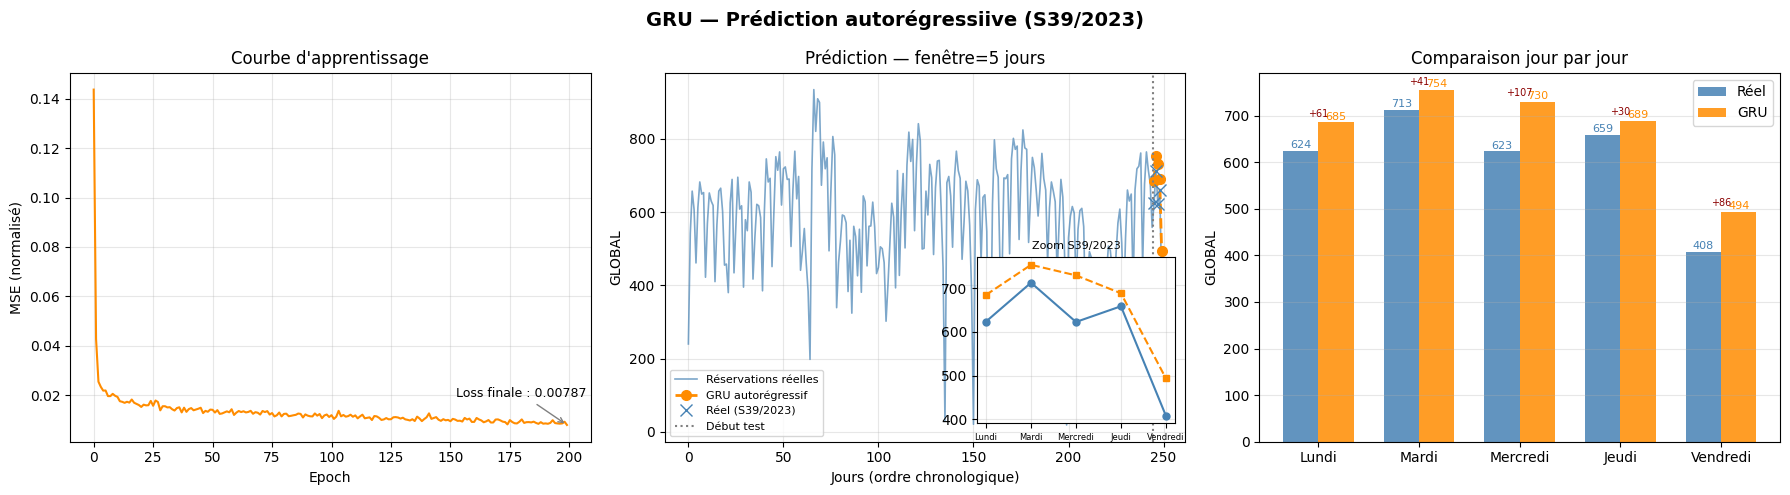

Figure sauvegardée → ../img/gru_results.png


In [9]:
all_real     = df[TARGET_COL].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'{MODEL_NAME} — Prédiction autorégressiive ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Courbe d'apprentissage ────────────────────────────────────────────
ax = axes[0]
ax.plot(loss_history, color='darkorange', lw=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE (normalisé)')
ax.set_title('Courbe d\'apprentissage')
ax.grid(alpha=0.3)
ax.annotate(f'Loss finale : {loss_history[-1]:.5f}',
            xy=(len(loss_history) - 1, loss_history[-1]),
            xytext=(-80, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)

# ── 2 : Série complète + prédiction ─────────────────────────────────────
ax = axes[1]
ax.plot(range(len(all_real)), all_real,
        label='Réservations réelles', color='steelblue', alpha=0.7, lw=1.2)
ax.plot(test_indices, preds_real,
        label=f'{MODEL_NAME} autorégressif', color='darkorange',
        ls='--', marker='o', ms=7, lw=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', ms=9, ls='None', label=f'Réel ({TEST_LABEL})')
ax.axvline(x=test_indices[0] - 0.5, color='gray', ls=':', lw=1.5, label='Début test')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Prédiction — fenêtre={WINDOW} jours')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

axins = ax.inset_axes([0.60, 0.05, 0.38, 0.45])
axins.plot(DAY_LABELS, real_real, 'o-', color='steelblue', ms=5)
axins.plot(DAY_LABELS, preds_real, 's--', color='darkorange', ms=5)
axins.set_title(f'Zoom {TEST_LABEL}', fontsize=8)
axins.tick_params(axis='x', labelsize=6)
axins.grid(alpha=0.3)

# ── 3 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[2]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel',        color='steelblue',  alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label=MODEL_NAME,    color='darkorange', alpha=0.85)
for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Comparaison jour par jour')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i in range(N_TEST):
    err = preds_real[i] - real_real[i]
    ax.text(i, max(real_real[i], preds_real[i]) + 12,
            f'{err:+.0f}', ha='center', fontsize=7, color='darkred')

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 10 — Trace de la fenêtre glissante

In [10]:
print(f'=== Trace de la fenêtre glissante — {MODEL_NAME} ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7} {'Err abs':>8} {'Err %':>7}   Rôle")
print('-' * 75)
for i, d in enumerate(DAY_LABELS):
    err_abs = abs(preds_real[i] - real_real[i])
    err_pct = 100 * err_abs / real_real[i]
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f} {err_abs:>8.1f} {err_pct:>6.1f}%   {role}')

print(f'\nRésumé : MAE={mae:.1f} | MAPE={mape:.2f}% | RMSE={rmse:.1f} | R²={r2:.4f}')

=== Trace de la fenêtre glissante — GRU ===
Étape   Jour           Réel  Prédit  Err abs   Err %   Rôle
---------------------------------------------------------------------------
  0      Lundi           624     685     61.2    9.8%   ← injecté dans la fenêtre suivante
  1      Mardi           713     754     41.0    5.8%   ← injecté dans la fenêtre suivante
  2      Mercredi        623     730    106.8   17.1%   ← injecté dans la fenêtre suivante
  3      Jeudi           659     689     29.8    4.5%   ← injecté dans la fenêtre suivante
  4      Vendredi        408     494     85.7   21.0%   ← prédiction finale

Résumé : MAE=64.9 | MAPE=11.64% | RMSE=70.8 | R²=0.5366
